In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [5]:
# Load dataset
df = pd.read_csv("/content/credit_risk_dataset.csv")

In [6]:
# Check initial structure
print("Initial Shape:", df.shape)


Initial Shape: (32581, 12)


In [7]:
# Fill or drop missing values if any
df = df.dropna()


In [8]:
# Encode categorical columns
categorical_cols = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [9]:
# Select features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']  # 1 = Default, 0 = Paid

In [10]:
# Normalize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
# Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
probs_lr = lr.predict_proba(X_test)[:, 1]


In [13]:
# CatBoost Classifier Model
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
probs_cat = cat_model.predict_proba(X_test)[:, 1]


In [14]:
# Business cost values
cost_fp = 1000  # Cost of wrongly approving defaulter
cost_fn = 500   # Cost of wrongly rejecting good customer


In [15]:
# Function to calculate business cost
def calculate_business_cost(y_true, probs, threshold, cost_fp, cost_fn):
    y_pred = (probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost

In [16]:
# Optimize threshold
thresholds = np.arange(0.1, 0.91, 0.01)
costs = [calculate_business_cost(y_test, probs_cat, t, cost_fp, cost_fn) for t in thresholds]
optimal_threshold = thresholds[np.argmin(costs)]


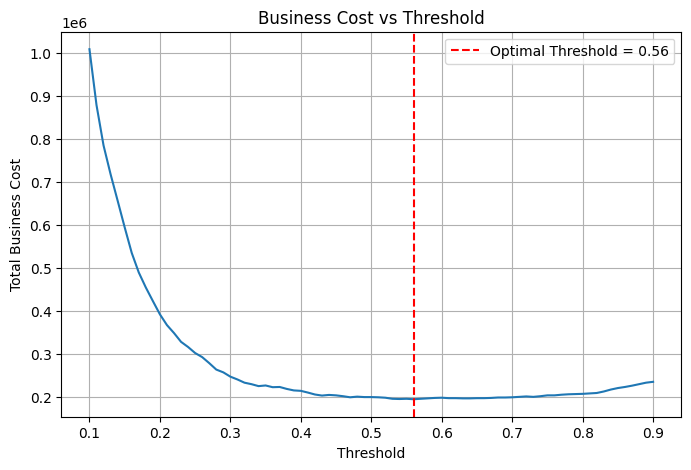

In [17]:
# Plot cost vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs)
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost")
plt.title("Business Cost vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Final confusion matrix & metrics
final_preds = (probs_cat >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()


In [19]:
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Total Business Cost: {(fp * cost_fp) + (fn * cost_fn)}")
print("ROC AUC Score:", roc_auc_score(y_test, probs_cat))

Optimal Threshold: 0.56
Confusion Matrix: TP=873, FP=11, TN=4476, FN=368
Total Business Cost: 195000
ROC AUC Score: 0.9427963350835173
